# UMA Raw data EDA

## Import Libraries

In [1]:
# analysis
import numpy as np
import pandas as pd
import requests

# other
import warnings

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


## Import Data

In [2]:
task = {"username": "gometro-system-admin",
        "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
        "client_id": "gometro-uma-service",
        "grant_type": "password",
       }

endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
resp = requests.post(endpoint, data=task)

if (resp.status_code < 200) and (resp.status_code >= 300):
    raise ValueError('POST /tasks/ {}'.format(resp.status_code))
    
token = resp.json()["access_token"]

headers = {
    'Authorization': f'Bearer {token}',
}
endpoint = 'https://api.gometroapp.com/uma/v1/participants/e2dc773b-15e0-4451-8c09-faf5ed644699/events/2021-01-14'
response = requests.get(endpoint, headers=headers)

In [3]:
import pandas as pd
df = pd.DataFrame(response.json())
print(df.shape)
df.head()

(4009, 3)


timestamp                    type  \
0      2021-01-14T02:57:06Z         LocationChanged   
1   2021-01-14T02:57:11.25Z  SatelliteStatusChanged   
2      2021-01-14T02:57:15Z         LocationChanged   
3  2021-01-14T02:57:22.244Z  SatelliteStatusChanged   
4      2021-01-14T02:57:25Z         LocationChanged   

                                             payload  
0  {"provider":"gps","latitude":-23.5040615173056...  
1                               {"satelliteCount":6}  
2  {"provider":"gps","latitude":-23.5041105514392...  
3                               {"satelliteCount":5}  
4  {"provider":"gps","latitude":-23.5041146166622...

## Assess Data

Assessing the event types we are receiving from the API

In [4]:
print(f"Number of categories: {len(df['type'].unique())}")
df['type'].value_counts()

Number of categories: 13


LocationChanged             1873
SatelliteStatusChanged      1065
MemoryStatusChanged          674
DeviceSettingsUpdated        204
GpsSystemStarted              71
GpsSystemStopped              71
Warning                       21
GpsSystemFirstFix             16
Error                          4
LocationProviderEnabled        4
LocationProviderDisabled       4
PowerDisconnected              1
PowerConnected                 1
Name: type, dtype: int64

Let us look at the payloads of the different `type` categories.

In [5]:
for category in df['type'].unique():
    print(category)
    print(df[df['type'] == category].iloc[0,2], '\n')

LocationChanged
{"provider":"gps","latitude":-23.504061517305672,"longitude":-46.71790902502835,"accuracy":38,"bearing":198.89999389648438,"speed":1.2400000095367432} 

SatelliteStatusChanged
{"satelliteCount":6} 

MemoryStatusChanged
{"availableMemory":965369856,"lowMemory":false,"threshold":92937216,"totalMemory":3909599232} 

DeviceSettingsUpdated
{"settings":[null,null,null,null,null,{"name":"tracking.enabled","stringValue":"true","type":"BOOLEAN","lastModified":0,"serializable":true,"externalizable":true},{"name":"core.debug","stringValue":"false","type":"BOOLEAN","lastModified":0,"serializable":true,"externalizable":true,"mutable":false}]} 

PowerConnected
{} 

GpsSystemStopped
{} 

Error
{"message":"[OAuthIdentityService.getTokens] java.net.UnknownHostException: Unable to resolve host \"identity.gometroapp.com\": No address associated with hostname"} 

GpsSystemStarted
{} 

GpsSystemFirstFix
{} 

PowerDisconnected
{} 

Warning
{"message":"[DeviceEventsService.flush] Network Unav

**Data Dictionary**

* `timestamp`: date and time waypoint was captured, UTC Timezome
* `type`: indicates the type of data contained in the payload
    * `LocationChanged`: Labels data with geographical observations in the payload
    * `SatelliteStatusChanged`: Labels data with the number of satellites connected to device
* `payload`: the payload of the data


The data required for this exercise is the data containing the waypoints, which is where the `type` category is `LocationChanged`

In [6]:
df_waypoints = df[
    df['type'] == 'LocationChanged'
]
print(df_waypoints.shape)
df_waypoints.head()

(1873, 3)


timestamp             type  \
0  2021-01-14T02:57:06Z  LocationChanged   
2  2021-01-14T02:57:15Z  LocationChanged   
4  2021-01-14T02:57:25Z  LocationChanged   
6  2021-01-14T02:57:32Z  LocationChanged   
8  2021-01-14T02:57:42Z  LocationChanged   

                                             payload  
0  {"provider":"gps","latitude":-23.5040615173056...  
2  {"provider":"gps","latitude":-23.5041105514392...  
4  {"provider":"gps","latitude":-23.5041146166622...  
6  {"provider":"gps","latitude":-23.504145629704,...  
8  {"provider":"gps","latitude":-23.5040944162756...

In [7]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # import literal_eval function
    from ast import literal_eval

    # make list of column headers from keys
    payload_cols = literal_eval(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df_waypoints['payload'].apply(lambda x: literal_eval(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df



Unpacking the payload and updating the table

In [8]:
df_waypoints = unpack_payload(df_waypoints)
print(df_waypoints.shape)
df_waypoints.head()

(1873, 7)


timestamp provider   latitude  longitude  accuracy     bearing  \
0  2021-01-14T02:57:06Z      gps -23.504062 -46.717909      38.0  198.899994   
2  2021-01-14T02:57:15Z      gps -23.504111 -46.717916      29.5  226.800003   
4  2021-01-14T02:57:25Z      gps -23.504115 -46.717864      27.5   53.099998   
6  2021-01-14T02:57:32Z      gps -23.504146 -46.717827      24.0  162.899994   
8  2021-01-14T02:57:42Z      gps -23.504094 -46.717802      23.5    0.000000   

   speed  
0   1.24  
2   1.26  
4   1.21  
6   1.13  
8   0.00

Data types and null values

In [9]:
df_waypoints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 0 to 4008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1873 non-null   object 
 1   provider   1873 non-null   object 
 2   latitude   1873 non-null   float64
 3   longitude  1873 non-null   float64
 4   accuracy   1873 non-null   float64
 5   bearing    1873 non-null   float64
 6   speed      1873 non-null   float64
dtypes: float64(5), object(2)
memory usage: 117.1+ KB


## Univariate Analysis

1. Categorical variables
1. Numerical variables

### Categorical variables

1. `timestamps`
2. `provider`

Assessing `timestamps`

In [10]:
df_waypoints['timestamp'].value_counts()

2021-01-14T03:18:46.403Z    1
2021-01-14T15:26:52Z        1
2021-01-14T22:55:03.114Z    1
2021-01-14T12:13:03.813Z    1
2021-01-14T19:23:44.688Z    1
                           ..
2021-01-14T16:44:12.766Z    1
2021-01-14T12:07:43.195Z    1
2021-01-14T12:04:32Z        1
2021-01-14T15:41:27.995Z    1
2021-01-14T15:25:46Z        1
Name: timestamp, Length: 1873, dtype: int64

Assessing `provider`

In [11]:
df_waypoints['provider'].value_counts()

gps        1001
network     872
Name: provider, dtype: int64

In [12]:
df_waypoints['provider'].value_counts(normalize=True)

gps        0.534437
network    0.465563
Name: provider, dtype: float64

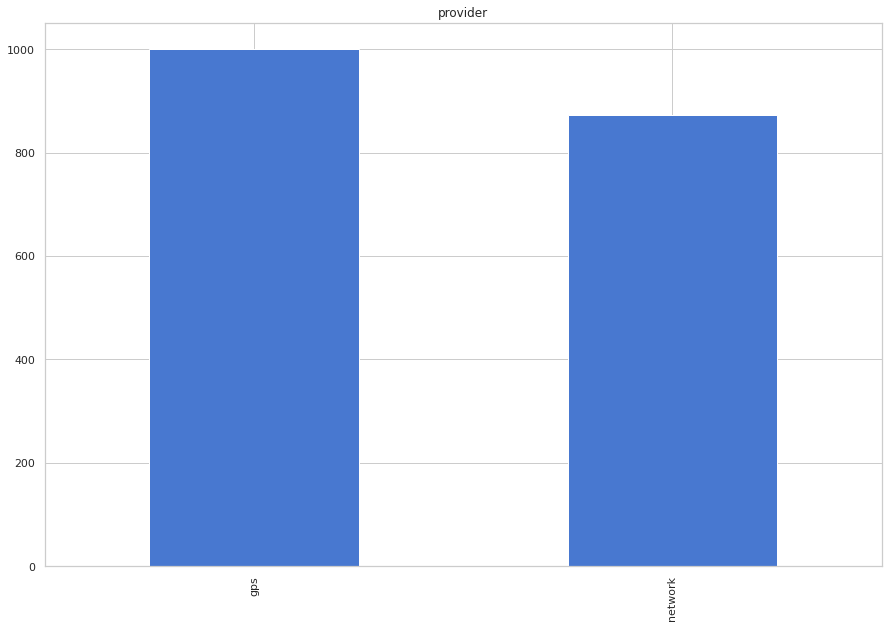

In [13]:
# column to visualise
col = 'provider'

df_waypoints[col].value_counts().plot(kind='bar')
plt.title(col)
plt.show()


### Numerical variables

1. `accuracy`
1. `bearing`
1. `speed`

In [14]:
df_waypoints.describe().drop(['latitude', 'longitude'], axis=1)

accuracy      bearing        speed
count  1873.000000  1873.000000  1873.000000
mean     36.166674    90.548852     2.462356
std      99.156585   115.072672     5.575022
min       2.109174     0.000000     0.000000
25%      12.500000     0.000000     0.000000
50%      24.351000     8.500000     0.170000
75%      30.962000   181.500000     1.420000
max    2200.000000   359.700012    25.480000

Assessing `accuracy`

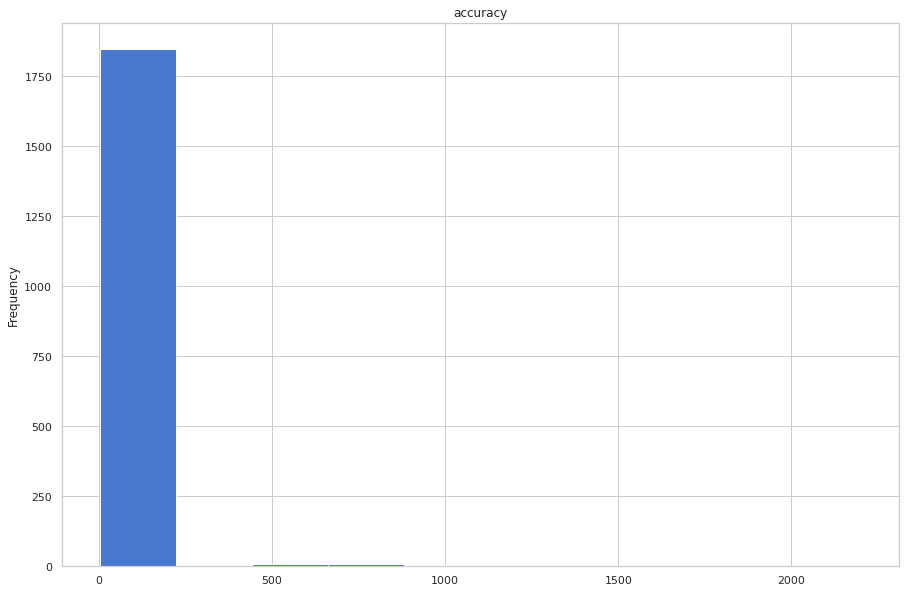

In [15]:
# column to visualise
col = 'accuracy'

df_waypoints[col].plot(kind='hist')
plt.title(col)
plt.show()

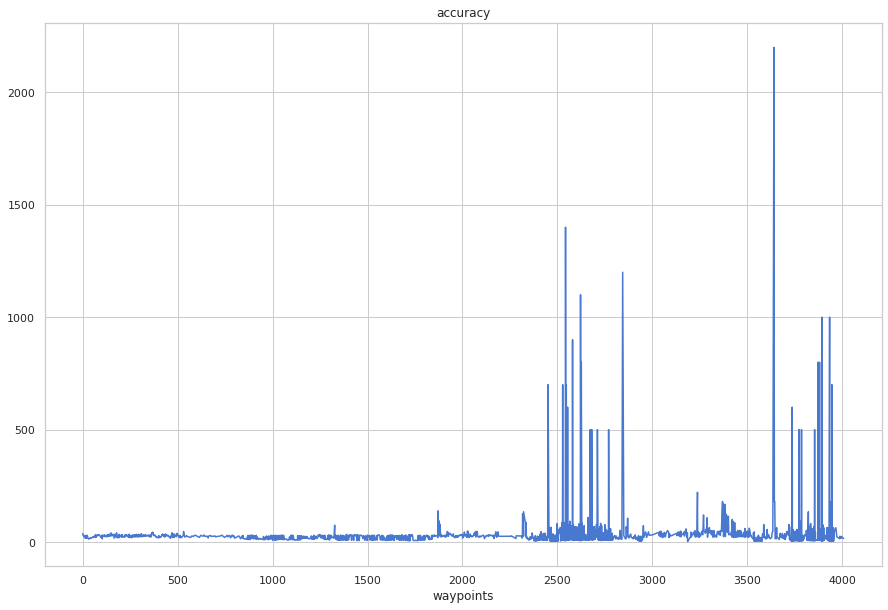

In [16]:
df_waypoints[col].plot(kind='line')
plt.title(col)
plt.xlabel('waypoints')
plt.show()

Assessing `bearing`

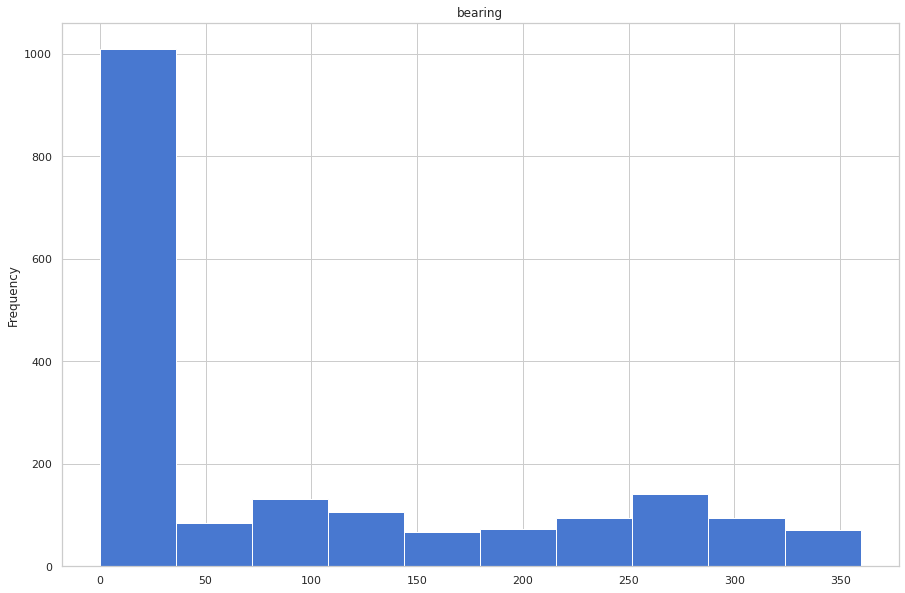

In [17]:
# column to visualise
col = 'bearing'

df_waypoints[col].plot(kind='hist')
plt.title(col)
plt.show()

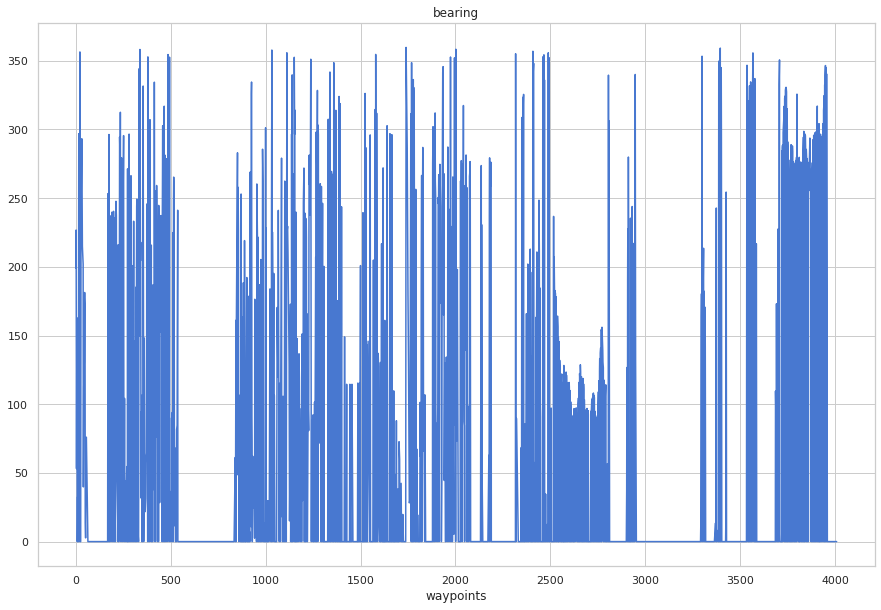

In [18]:
df_waypoints[col].plot(kind='line')
plt.title(col)
plt.xlabel('waypoints')
plt.show()

Assessing `speed`

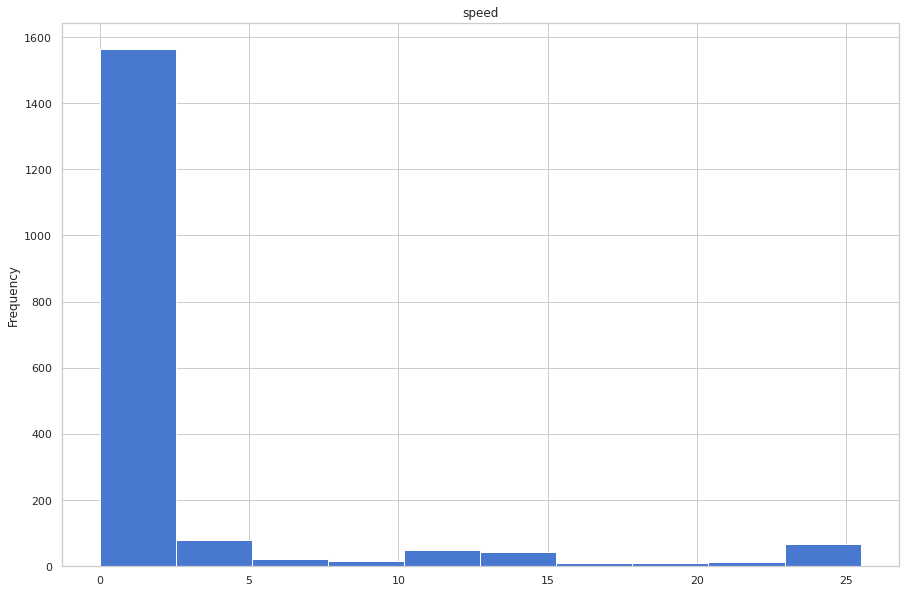

In [19]:
# column to visualise
col = 'speed'

df_waypoints[col].plot(kind='hist')
plt.title(col)
plt.show()

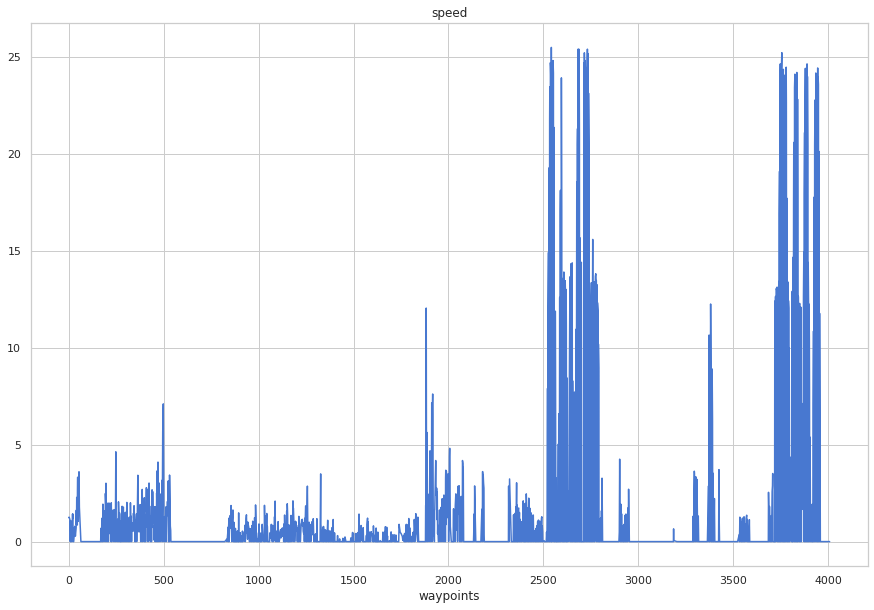

In [20]:
df_waypoints[col].plot(kind='line')
plt.title(col)
plt.xlabel('waypoints')
plt.show()